In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
# Step 1: Define the data
sentences = [
    # Animal group 
    "The cat chases mouse",  # Removed "the" to make 5 words
    "The dog chases cat",    # Removed "the" to make 5 words
    "The lion hunts gazelle", # Removed "the" to make 5 words
    # Nature group
    "The tree sways in wind", # Removed "the" to make 5 words
    "The flower blooms in spring",
    "The grass grows in sunlight",
    # Human group
    "The teacher writes on board",
    "The student reads the book",
    "The worker builds the house"
]

# Assign group labels (0: Animal, 1: Nature, 2: Human)
groups = [0, 0, 0, 1, 1, 1, 2, 2, 2]

def prepare_data(sentences):
    """Create vocabulary and encode sentences"""
    # Create vocabulary
    words = set()
    for sentence in sentences:
        words.update(sentence.lower().split())
    vocab = {word: idx+1 for idx, word in enumerate(sorted(words))}
    
    # Encode sentences
    encoded = []
    max_len = 5  # Set fixed length for all sentences
    for sentence in sentences:
        # Pad or truncate to max_len
        words = sentence.lower().split()
        if len(words) > max_len:
            words = words[:max_len]
        elif len(words) < max_len:
            words = words + [''] * (max_len - len(words))
        encoded.append([vocab.get(word, 0) for word in words])
    
    return vocab, encoded

class SpectralRegularizedModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # Initialize A and B matrices separately
        self.A = nn.Parameter(torch.randn(vocab_size, embedding_dim) / np.sqrt(embedding_dim))
        self.B = nn.Parameter(torch.randn(vocab_size, embedding_dim) / np.sqrt(embedding_dim))
        
    def get_transformation_matrix(self):
        """Get the full ABᵀ transformation matrix"""
        return torch.mm(self.A, self.B.t())
    
    def forward(self, x):
        """
        x: batch of sentence indices [batch_size, seq_len]
        returns: sentence embeddings [batch_size, embedding_dim]
        """
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x)
        
        # Create mask for padding
        mask = (x != 0).float().unsqueeze(-1)
        
        # Get embeddings using A matrix
        embedded = self.A[x]  # [batch_size, seq_len, embedding_dim]
        
        # Apply mask and average
        masked = embedded * mask
        summed = masked.sum(dim=1)  # [batch_size, embedding_dim]
        lengths = mask.sum(dim=1)
        lengths[lengths == 0] = 1
        averaged = summed / lengths
        
        return averaged

    def compute_spectral_regularization(self, X, lambda_reg):
        """Compute spectral regularization term following paper's formulation"""
        ABt = self.get_transformation_matrix()
        XABt = torch.mm(X, ABt)
        
        try:
            U, S, V = torch.svd(XABt)
            reg_term = torch.sum(S**2 / (1 + lambda_reg/(S**2 + 1e-8)))
            return reg_term
        except RuntimeError:
            return torch.norm(XABt, p='fro')**2

def create_sparse_matrix(sentences, vocab_size):
    """Convert sentences to sparse matrix format"""
    X = torch.zeros(len(sentences), vocab_size)
    for i, sent in enumerate(sentences):
        for word_idx in sent:
            X[i, word_idx] += 1
    return X

def train_spectral_model(sentences, vocab, model_params):
    """Train model with proper spectral regularization"""
    vocab_size = len(vocab) + 1  # +1 for padding
    model = SpectralRegularizedModel(vocab_size, model_params['embedding_dim'])
    
    # Convert sentences to sparse matrix format
    X = create_sparse_matrix([torch.tensor(s) for s in sentences], vocab_size)
    
    # Setup optimizer
    optimizer = optim.Adam(model.parameters(), lr=model_params['lr'])
    
    # Training loop
    for epoch in range(model_params['epochs']):
        total_loss = 0
        
        # Compute embeddings for all sentences
        batch_embeds = model(torch.tensor(sentences))
        
        # Compute similarity matrix
        sim_matrix = torch.mm(batch_embeds, batch_embeds.t())
        
        # Compute triplet loss
        loss = 0
        for i, group_i in enumerate(groups):
            pos_indices = [j for j, g in enumerate(groups) if g == group_i and j != i]
            neg_indices = [j for j, g in enumerate(groups) if g != group_i]
            
            if pos_indices and neg_indices:
                pos_sims = sim_matrix[i, pos_indices]
                neg_sims = sim_matrix[i, neg_indices]
                
                loss += torch.mean(torch.relu(
                    neg_sims.unsqueeze(0) - pos_sims.unsqueeze(1) + model_params['margin']
                ))
        
        # Add spectral regularization
        spec_reg = model.compute_spectral_regularization(X, model_params['weight_decay'])
        loss = loss + model_params['weight_decay'] * spec_reg
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss:.4f}")
    
    return model

def analyze_spectral_model(model, sentences):
    """Analyze embeddings from spectral model"""
    with torch.no_grad():
        # Get original embeddings
        embeds = []
        for sent in sentences:
            embed = model(torch.tensor([sent]))
            embeds.append(embed.numpy()[0])
        embeddings = np.array(embeds)
        
        # Calculate original similarities
        original_sim = cosine_similarity(embeddings)
        
        # Apply scaling
        scaled_embeddings = embeddings.copy()
        dim = embeddings.shape[1]
        scaling = np.ones(dim)
        scaling[:dim//2] = 0.1
        scaling[dim//2:] = 10.0
        scaled_embeddings = scaled_embeddings * scaling
        
        # Calculate scaled similarities
        scaled_sim = cosine_similarity(scaled_embeddings)
        
        return original_sim, scaled_sim

def visualize_similarity_changes(sentences, original_sim, scaled_sim, reg_type=""):
    """Create visualization of similarity changes"""
    fig = plt.figure(figsize=(20, 6))
    
    # 1. Semantic Group Coherence
    ax1 = plt.subplot(131)
    
    # Calculate average within-group similarity
    groups_dict = {
        'Animal': (0, 3),
        'Nature': (3, 6),
        'Human': (6, 9)
    }
    
    # Calculate group scores
    group_scores = []
    for group_name, (start, end) in groups_dict.items():
        orig_group_sim = []
        scaled_group_sim = []
        for i in range(start, end):
            for j in range(i+1, end):
                orig_group_sim.append(original_sim[i][j])
                scaled_group_sim.append(scaled_sim[i][j])
        
        group_scores.append({
            'name': group_name,
            'original': np.mean(orig_group_sim),
            'scaled': np.mean(scaled_group_sim),
            'change': np.mean(scaled_group_sim) - np.mean(orig_group_sim)
        })
    
    # Plot group coherence
    x = np.arange(len(groups_dict))
    width = 0.35
    ax1.bar(x - width/2, [s['original'] for s in group_scores], width, 
            label='Original', color='skyblue')
    ax1.bar(x + width/2, [s['scaled'] for s in group_scores], width,
            label='After Scaling', color='lightcoral')
    
    ax1.set_ylabel('Average Within-Group Similarity')
    ax1.set_title('Semantic Group Coherence')
    ax1.set_xticks(x)
    ax1.set_xticklabels([s['name'] for s in group_scores])
    ax1.legend()
    ax1.set_ylim(0, 1)
    
    # 2. Ranking Preservation
    ax2 = plt.subplot(132)
    
    def get_ranking_preservation(orig_sim, scaled_sim, start, end):
        preservation = 0
        for i in range(start, end):
            orig_ranks = np.argsort(-orig_sim[i])
            scaled_ranks = np.argsort(-scaled_sim[i])
            # Check overlap in top 3
            orig_top3 = set(orig_ranks[1:4])  # exclude self
            scaled_top3 = set(scaled_ranks[1:4])
            preservation += len(orig_top3.intersection(scaled_top3)) / 3
        return preservation / (end - start)
    
    preservation_scores = []
    for group_name, (start, end) in groups_dict.items():
        score = get_ranking_preservation(original_sim, scaled_sim, start, end)
        preservation_scores.append(score)
    
    ax2.bar(groups_dict.keys(), preservation_scores, color='lightgreen')
    ax2.set_ylabel('Ranking Preservation Score')
    ax2.set_title('Top-3 Similar Sentences Preservation')
    ax2.set_ylim(0, 1)
    
    # 3. Distribution of Changes
    ax3 = plt.subplot(133)
    changes = np.abs(scaled_sim - original_sim)
    
    violin_data = []
    for group_name, (start, end) in groups_dict.items():
        group_changes = []
        for i in range(start, end):
            for j in range(len(sentences)):
                if i != j:
                    group_changes.append(changes[i][j])
        violin_data.append(group_changes)
    
    vp = ax3.violinplot(violin_data, showmeans=True)
    ax3.set_xticks(np.arange(1, len(groups_dict) + 1))
    ax3.set_xticklabels(groups_dict.keys())
    ax3.set_ylabel('Absolute Similarity Change')
    ax3.set_title('Distribution of Similarity Changes')
    
    for pc in vp['bodies']:
        pc.set_facecolor('lightblue')
        pc.set_alpha(0.7)
    
    plt.suptitle(f'{reg_type} - Stability Analysis', fontsize=16, y=1.05)
    plt.tight_layout()
    
    # Print summary statistics
    print(f"\n{reg_type} Summary:")
    print("Group Coherence Changes:")
    for score in group_scores:
        print(f"  {score['name']}: {score['change']:.3f}")
    print(f"Average Ranking Preservation: {np.mean(preservation_scores):.3f}")
    print(f"Max Absolute Change: {np.max(changes):.3f}")
    
    return fig


Training spectral regularized model...
Epoch 0, Loss: 4.7783
Epoch 10, Loss: 4.4325
Epoch 20, Loss: 4.0704
Epoch 30, Loss: 3.6493
Epoch 40, Loss: 3.1374
Epoch 50, Loss: 2.5091
Epoch 60, Loss: 1.7519
Epoch 70, Loss: 1.0025
Epoch 80, Loss: 0.4401
Epoch 90, Loss: 0.1371

Analyzing results...

Spectral Regularization Summary:
Group Coherence Changes:
  Animal: -0.048
  Nature: -0.046
  Human: -0.020
Average Ranking Preservation: 0.815
Max Absolute Change: 0.229


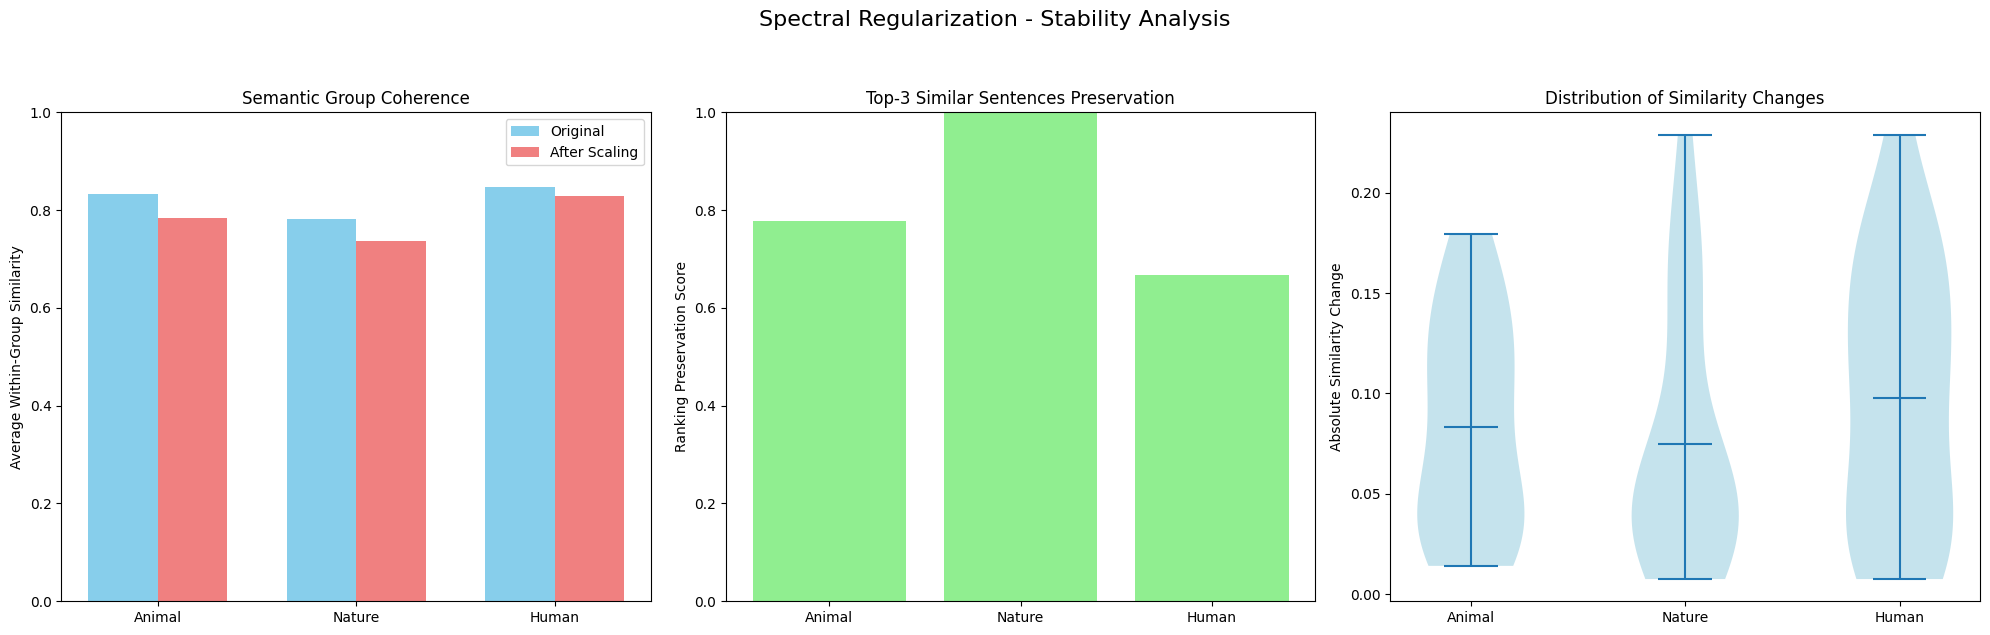

In [8]:
# Prepare data
vocab, encoded_sentences = prepare_data(sentences)

# Set model parameters
model_params = {
    'embedding_dim': 50,
    'lr': 0.001,
    'epochs': 100,
    'margin': 0.5,
    'weight_decay': 0.01
}

# Train model
print("Training spectral regularized model...")
spectral_model = train_spectral_model(encoded_sentences, vocab, model_params)

# Analyze results
print("\nAnalyzing results...")
orig_sim, scaled_sim = analyze_spectral_model(spectral_model, encoded_sentences)

# Visualize results
fig = visualize_similarity_changes(sentences, orig_sim, scaled_sim, "Spectral Regularization")
plt.show()